In [642]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.despine()
sns.set()
import numpy,pickle
from jax.tree_util import tree_map

from jax import jit,vmap
import pandas as pd
import blackjax

import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import plot_raster as pr
import gm_plot as gp
import gm_plot_diagnostic as gpd

import copy

%matplotlib inline
import gm_glm_bayesian as glm

In [205]:
sns.despine()
sns.set()

<Figure size 432x288 with 0 Axes>

In [2]:
def duplicate_dict(d,N=(10,1),to_exclude=['dt']):
    dd = {}
    for k,v in d.items():
        if k not in to_exclude:
            dd[k] = np.squeeze(np.tile(v,N))
        else:
            dd[k]=v
    return dd

In [3]:
savefig_dir = '/mnt/home/szheng/ceph/place_variability/fig/committee1'

In [4]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

In [66]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = 0

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


regressors=glm.get_regressors(fr)
target = fr[unit_str].values
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


In [528]:
ntime_in_trial = 950
artificial_position = np.linspace(1,219,ntime_in_trial)

In [96]:
len(artificial_position)

950

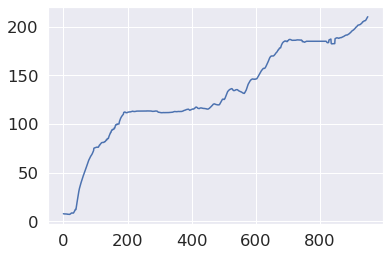

In [560]:
inds = slice(250,1200)
regressors_sim = {'trial_inds_int':regressors['trial_inds_int'][inds],'position':regressors['position'][inds],'dt':regressors['dt']}
# regressors_sim = {'trial_inds_int':regressors['trial_inds_int'][inds],'position':artificial_position,'dt':regressors['dt']}
plt.plot(regressors_sim['position'])

In [385]:
# generate multiple trials using the same param
ntrials = 1
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
# pars_sim = {'logws':np.array([[60.,80.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = {'logws':np.array([[60.]]),'mus':np.array([[90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.]])}
pars_sim = {'logws':np.array([[60.]]),'mus':np.array([[100]]),'logb':np.array([-10000000.]),'logsigmas':np.array([[20.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)




In [386]:
def get_regressor_df(regressors,target_spk):
    regressors_df = pd.DataFrame(regressors)
    regressors_df['spk']=target_spk
    posbin_l, bin_edges = pd.cut(regressors_df['position'],bins=221,retbins=True,labels=False)
    regressors_df['position_bin'] = posbin_l
    return regressors_df
def get_com_from_regressors(regressors,target_spk):
    regressors_df = get_regressor_df(regressors,target_spk)
    mean_fr_per_bin = regressors_df.groupby('position_bin').mean()
    com = (mean_fr_per_bin['position'] * mean_fr_per_bin['spk']).sum() / (mean_fr_per_bin['spk'].sum())
    return com,mean_fr_per_bin
    

In [387]:
def gen_spk_get_com(target_rate,regressors_sim_dup,N=100):
    com_l = []
    for i in range(N):
        target_spk = numpy.random.poisson(target_rate)
        com,_ = get_com_from_regressors(regressors_sim_dup,target_spk)
        com_l.append(com)
    return numpy.array(com_l)

In [388]:
def com_from_map(rate_vs_position,position):
    com = np.sum(rate_vs_position * position) / np.sum(rate_vs_position)
    return com

def gen_spk_get_com_map_version(target_rate,regressors_sim_dup,N=100):
    com_l = []
    
    regressors_sim_df=get_regressor_df(regressors_sim_dup,target_rate)
    mean_fr_per_bin_fr = regressors_sim_df.groupby(['position_bin']).mean()['spk']
    occupancy_per_bin = regressors_sim_df.groupby(['position_bin'])['dt'].count().values
    positions=numpy.array(regressors_sim_df.groupby(['position_bin'])['dt'].count().index)
    
    for i in range(N):
        spk_vs_position = numpy.random.poisson(mean_fr_per_bin_fr * occupancy_per_bin).astype(float)
        rate_vs_position = numpy.divide(spk_vs_position, occupancy_per_bin, out=numpy.zeros_like(spk_vs_position),where=occupancy_per_bin!=0)
        
        com = com_from_map(rate_vs_position,positions)
        com_l.append(com)
    return numpy.array(com_l)

In [179]:
com_l_single = gen_spk_get_com(target_rate,regressors_sim_dup,N=5000)

/tmp/ipykernel_3881550/1994457044.py:10: RuntimeWarning: invalid value encountered in double_scalars
  com = (mean_fr_per_bin['position'] * mean_fr_per_bin['spk']).sum() / (mean_fr_per_bin['spk'].sum())


(80.0, 100.0)

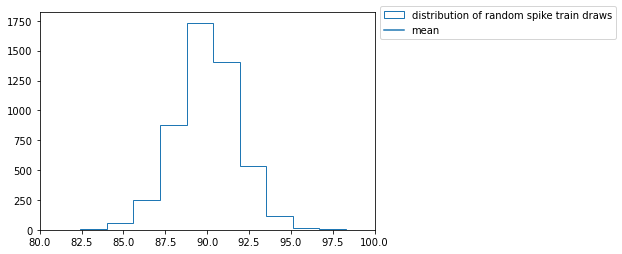

In [183]:
fig,ax=plt.subplots()
toplot=com_l_single
ax.hist(toplot,histtype='step',label='distribution of random spike train draws')
ax.axvline(numpy.mean(toplot),label='mean')
ax.legend(bbox_to_anchor=[1,1.05])
ax.set_xlim([80,100])

In [109]:
fig.savefig(os.path.join(savefig_dir,'random_draw_com_distribution_single_trial.pdf'),bbox_inches='tight')

In [188]:
# generate multiple trials using the same param
ntrials = 20
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
# pars_sim = {'logws':np.array([[60.,80.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = {'logws':np.array([[60.]]),'mus':np.array([[90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)




In [189]:
com_l_trial_avg = gen_spk_get_com(target_rate,regressors_sim_dup,N=5000)

(70.0, 160.0)

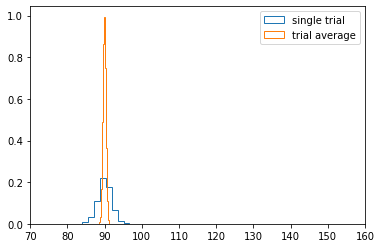

In [190]:
fig,ax=plt.subplots()
ax.hist(com_l_single,density=True,label='single trial',histtype='step')
ax.hist(com_l_trial_avg,histtype='step',label='trial average',density=True)
# ax.axvline(numpy.mean(com_l_trial_avg),label='mean_avg')
# ax.axvline(numpy.mean(com_l_single),label='mean_single')
ax.legend(bbox_to_anchor=[1,1])
ax.set_xlim([70,160])

In [137]:
fig.savefig(os.path.join(savefig_dir,'random_draw_com_distribution_single_20trials.pdf'),bbox_inches='tight')


(0.0, 0.14)

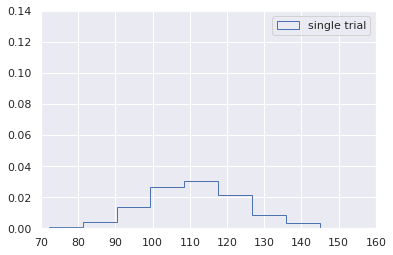

In [139]:
fig,ax=plt.subplots()
ax.hist(com_l_single,density=True,label='single trial',histtype='step')
# ax.hist(com_l_trial_avg,histtype='step',label='trial average',density=True)
# ax.axvline(numpy.mean(com_l_trial_avg),label='mean_avg')
# ax.axvline(numpy.mean(com_l_single),label='mean_single')
ax.legend(bbox_to_anchor=[1,1])
ax.set_xlim([70,160])
ax.set_ylim([0,0.14])

# demonstrate model

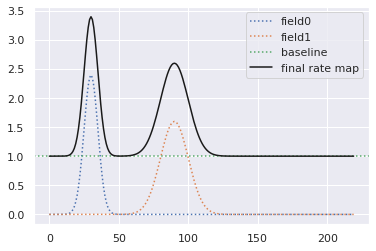

In [157]:
xs = np.arange(220)
mus = [30,90]
sigmas=[5,10]
ws = [30,40]
b=1
fig,ax=plt.subplots()
nk=len(mus)
f = 0
for k in range(nk):
    fk = scipy.stats.norm.pdf(xs,loc=mus[k],scale=sigmas[k]) * ws[k]
    ax.plot(fk,alpha=1,label=f'field{k}',linestyle=':')
    f+=fk
ax.axhline(b,label='baseline',alpha=1,linestyle=':',color=f'C{nk}')
f+=b
ax.plot(f,label='final rate map',color='k')
ax.legend()

In [404]:
# generate multiple trials using the same param
ntrials = 1
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
# pars_sim = {'logws':np.array([[60.,80.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = {'logws':np.array([[60.]]),'mus':np.array([[90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.]])}
pars_sim = {'logws':np.array([[60.]]),'mus':np.array([[80]]),'logb':np.array([-10000000.]),'logsigmas':np.array([[10.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)

[]

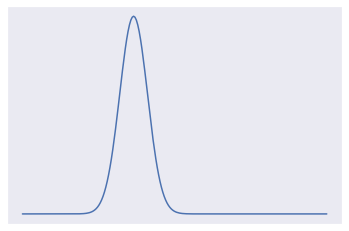

In [468]:
xs = np.arange(220)
fk = scipy.stats.norm.pdf(xs,loc=pars_sim['mus'][0][0],scale=gm.softplus(pars_sim['logsigmas'][0][0]))
fig,ax=plt.subplots()
ax.plot(fk)
ax.axes.set_xticks([])
ax.axes.set_yticks([])

[]

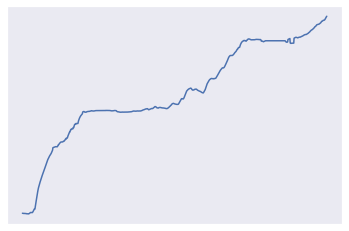

In [561]:
inds = slice(250,1200)
regressors_sim = {'trial_inds_int':regressors['trial_inds_int'][inds],'position':regressors['position'][inds],'dt':regressors['dt']}
fig,ax=plt.subplots()
ax.plot(regressors_sim['position'])
ax.axes.set_xticks([])
ax.axes.set_yticks([])


[]

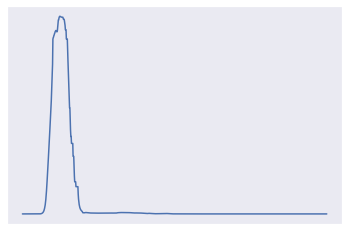

In [470]:
fig,ax=plt.subplots()
ax.plot(target_rate[:950])
ax.axes.set_xticks([])
ax.axes.set_yticks([])


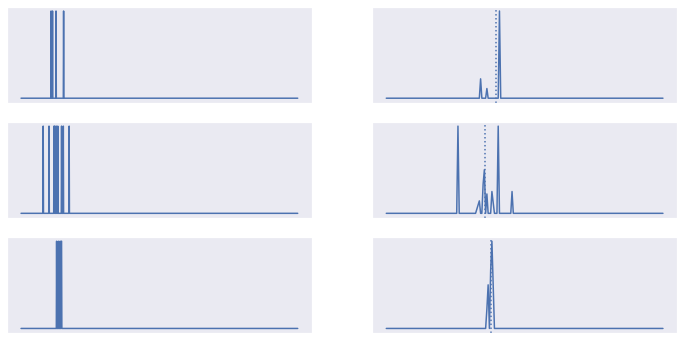

In [522]:
nrepeats = 3
fig,axs = plt.subplots(nrepeats,2,figsize=(6*2,2*nrepeats))
numpy.random.seed(0)
fr_map_spk_onetrial_l = []
com_l = []
for n in range(nrepeats):
    spk = numpy.random.poisson(target_rate[:950])
    axs[n,0].plot(spk)
    axs[n,0].axes.set_xticks([])
    axs[n,0].axes.set_yticks([])
    
    com,fr_map_spk_onetrial=get_com_from_regressors(regressors_sim,spk)
    com_l.append(com)
    fr_map_spk_onetrial_l.append(fr_map_spk_onetrial)
    axs[n,1].plot(fr_map_spk_onetrial.index,fr_map_spk_onetrial['spk'])
#     axs[n,1].axvline(com,c='C0',label='single',linestyle=':')
    axs[n,1].axes.set_xticks([])
    axs[n,1].axes.set_yticks([])

In [428]:
com_l_single = gen_spk_get_com(target_rate,regressors_sim_dup,N=5000)

/tmp/ipykernel_3881550/1994457044.py:10: RuntimeWarning: invalid value encountered in double_scalars
  com = (mean_fr_per_bin['position'] * mean_fr_per_bin['spk']).sum() / (mean_fr_per_bin['spk'].sum())
/tmp/ipykernel_3881550/1994457044.py:10: RuntimeWarning: invalid value encountered in double_scalars
  com = (mean_fr_per_bin['position'] * mean_fr_per_bin['spk']).sum() / (mean_fr_per_bin['spk'].sum())
/tmp/ipykernel_3881550/1994457044.py:10: RuntimeWarning: invalid value encountered in double_scalars
  com = (mean_fr_per_bin['position'] * mean_fr_per_bin['spk']).sum() / (mean_fr_per_bin['spk'].sum())
/tmp/ipykernel_3881550/1994457044.py:10: RuntimeWarning: invalid value encountered in double_scalars
  com = (mean_fr_per_bin['position'] * mean_fr_per_bin['spk']).sum() / (mean_fr_per_bin['spk'].sum())
/tmp/ipykernel_3881550/1994457044.py:10: RuntimeWarning: invalid value encountered in double_scalars
  com = (mean_fr_per_bin['position'] * mean_fr_per_bin['spk']).sum() / (mean_fr_per_bin

Text(0, 0.5, 'density')

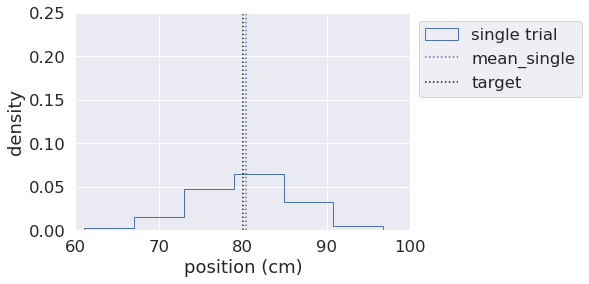

In [492]:
fig,ax=plt.subplots()
ax.hist(com_l_single,density=True,label='single trial',histtype='step')
# ax.hist(com_l_trial_avg,histtype='step',label='trial average',density=True)
# ax.axvline(numpy.mean(com_l_trial_avg),label='mean_avg')
ax.axvline(numpy.nanmean(com_l_single),label='mean_single',linestyle=':')
ax.axvline(pars_sim['mus'][0][0],label='target',c='k',linestyle=':')
ax.legend(bbox_to_anchor=[1,1])
ax.set_xlim([60,100])
ax.set_ylim([0,0.25])
ax.set_xlabel('position (cm)')
ax.set_ylabel('density')

In [433]:
# generate multiple trials using the same param
ntrials = 20
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
# pars_sim = {'logws':np.array([[60.,80.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = {'logws':np.array([[60.]]),'mus':np.array([[90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)


In [434]:
com_l_trial_avg = gen_spk_get_com(target_rate,regressors_sim_dup,N=5000)

Text(0, 0.5, 'density')

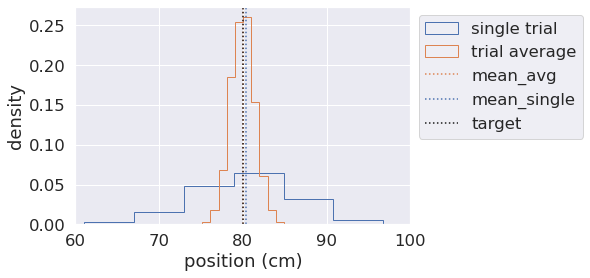

In [493]:
fig,ax=plt.subplots()
ax.hist(com_l_single,density=True,label='single trial',histtype='step')
ax.hist(com_l_trial_avg,histtype='step',label='trial average',density=True)
ax.axvline(numpy.nanmean(com_l_trial_avg),label='mean_avg',c='C1',linestyle=':')
ax.axvline(numpy.nanmean(com_l_single),label='mean_single',linestyle=':')
ax.axvline(pars_sim['mus'][0][0],label='target',c='k',linestyle=':')
ax.legend(bbox_to_anchor=[1,1])
ax.set_xlim([60,100])
ax.set_xlabel('position (cm)')
ax.set_ylabel('density')

In [504]:
np.nanquantile(com_l_single,0.99)

DeviceArray(94.66148, dtype=float32)

In [505]:
numpy.nanquantile(com_l_single,0.995)-numpy.nanquantile(com_l_single,0.005)

33.25961668241515

In [509]:
numpy.nanquantile(com_l_trial_avg,0.995)

83.6513313827678

In [506]:
numpy.nanquantile(com_l_trial_avg,0.995)-numpy.nanquantile(com_l_trial_avg,0.005)

7.325332245247438

In [510]:
33.25961668241515/7.3

4.556111874303445

In [502]:
numpy.nanstd(com_l_single) / numpy.nanstd(com_l_trial_avg)

4.220232445018877

# schematic for regularization

In [544]:
pars_sim_drift = {'logws':np.array([[60.],[60.],[60.]]),'mus':np.array([[80.],[85.],[90.]]),'logb':np.array([-10000000.,-10000000.,-10000000.]),'logsigmas':np.array([[10.],[10.],[10.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
ntrials_drift = pars_sim_drift['mus'].shape[0]
regressors_sim_dup_drift=duplicate_dict(regressors_sim,N=ntrials_drift)
regressors_sim_dup_drift['trial_inds_int'] =numpy.repeat(numpy.arange(ntrials_drift),ntime_in_trial)

target_rate_drift = glm.forward(regressors_sim_dup_drift,pars_sim_drift)

In [547]:
com_l

[86.15275626212927, 87.30758884033007, 88.82365562802269]

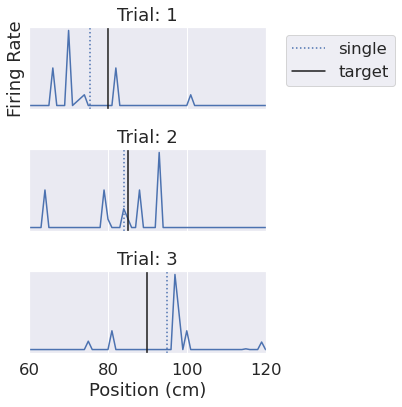

In [639]:
nrepeats = 3
fig,axs = plt.subplots(nrepeats,1,figsize=(6*1,2*nrepeats),sharex=True)
numpy.random.seed(13)
fr_map_spk_onetrial_l = []
com_l = []
for n in range(nrepeats):
    target_rate_currtrial =target_rate_drift[regressors_sim_dup_drift['trial_inds_int']==n]
    spk = numpy.random.poisson(target_rate_currtrial)
#     axs[n,0].plot(spk)
#     axs[n,0].axes.set_xticks([])
#     axs[n,0].axes.set_yticks([])
    
    com,fr_map_spk_onetrial=get_com_from_regressors(regressors_sim,spk)
    com_l.append(com)
    fr_map_spk_onetrial_l.append(fr_map_spk_onetrial)
    axs[n].plot(fr_map_spk_onetrial.index,fr_map_spk_onetrial['spk'])
    axs[n].axvline(com,c='C0',label='single',linestyle=':')
    axs[n].axvline(pars_sim_drift['mus'][n,0],c='k',label='target')
    axs[n].axes.set_xticks([60,80,100,120])
    axs[n].axes.set_yticks([])
    axs[n].axes.set_xlim([60,120])
    axs[n].set_title(f'Trial: {n+1}')

#     axs[n].

# axs[0].legend(bbox_to_anchor=[1.36,1])
axs[0].set_ylabel('Firing Rate')
axs[0].legend()
sns.move_legend(axs[0],"upper left",bbox_to_anchor=[1.05,1])
axs[-1].set_xlabel('Position (cm)')
plt.tight_layout()

com_l=numpy.array(com_l)

# fig.savefig(os.path.join(savefig_dir,'regularization_schematics1.pdf'),bbox_inches='tight')
fig

In [640]:
com_l_mean = numpy.mean(com_l)
for n in range(nrepeats):
    axs[n].axvline(com_l_mean,c='C1',linestyle=':',label='trial average')
axs[0].legend()
sns.move_legend(axs[0],"upper left",bbox_to_anchor=[1.05,1])

# fig.savefig(os.path.join(savefig_dir,'regularization_schematics2.pdf'),bbox_inches='tight')
fig

In [641]:
W=numpy.array([[0.625,0.25,0.125],[0.25,0.5,0.25],[0.125,0.25,0.625]])
com_l_reg = W.dot(com_l)
for n in range(nrepeats):
    axs[n].axvline(com_l_reg[n],c='r',linestyle=':',linewidth=3,label='regularization')
# axs[0].legend(bbox_to_anchor=[1.2,1])
axs[0].legend()
sns.move_legend(axs[0],"upper left",bbox_to_anchor=[1.05,1])

# fig.savefig(os.path.join(savefig_dir,'regularization_schematics3.pdf'),bbox_inches='tight')
fig

# example fit

In [ ]:
args=pr.preprocess_for_plot(sess_name,sigma=30,speedmask=5,n_pos_bins=100)
section_colordict,spk_triggered_positions_trial_all_speedmasked,pos_bins_dict,choice = args[4:8]


In [200]:
fit_res_dir = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/gm_fit/gm_cv_1'

pyr_names = numpy.array(fr_['cell_cols']['pyr'],dtype=object)

uid = 32
ind = numpy.nonzero(pyr_names==f'unit_{uid}')[0][0]


In [330]:
fit_kwargs = dict(reg_type = 'quad_variation',lr=0.05,loss_type='mse',niters=4000)
regressors = gm.get_regressor(regressors_={})
reg_pars_ = {'g_mu':0.1,'nfields':3,'g_sigma':100.0,'g_w':1000000.,'g_b':100}
reg_pars_ = gm.get_reg_pars(reg_pars_) # add in the default
ch = 0
ind = ind
fr_map_trial=fr_map_
ys_l = fr_map_trial[ch][ind]
pars_learned,loss_l = gm.fit(ys_l,regressors_=regressors,reg_pars_=reg_pars_,nfields=reg_pars_['nfields'],mask=None,**fit_kwargs)


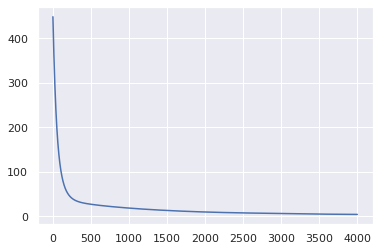

In [331]:
plt.plot(loss_l)

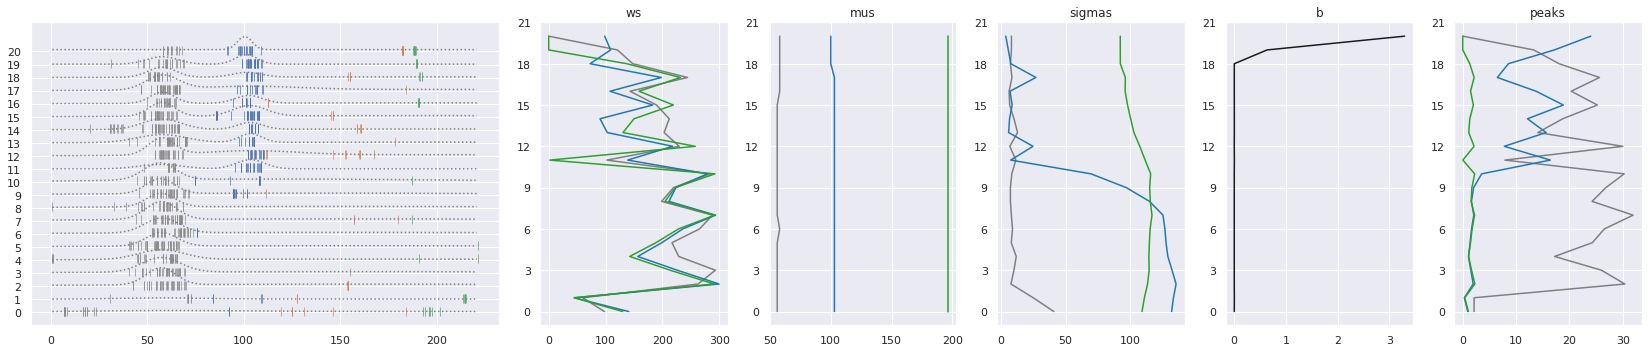

In [421]:
spk_triggered_positions_trial_ = spk_triggered_positions_trial_all_speedmasked[uid-1][choice==0]
section_colordict_trial = {k[-1]:section_colordict[k] for k in section_colordict.keys() if k[0]==ch}
reload(gp)
fig,axs=gp.plot_fit_original_raster_param_1trial(fr_map_trial,ind,choice,spk_triggered_positions_trial_,fig=None,axs=None,pars_learned=pars_learned,ch=0,gm_fit_dir=None,nooriginal=True,figsize=(23,5),bin_to_lin=bin_to_lin,nparams=5,displacement=None,section_colordict_trial=section_colordict_trial)


In [423]:
fig.savefig(os.path.join(savefig_dir,f'gmfit_ch{ch}_ind{ind}_uid{uid}.pdf'),bbox_inches='tight')

# toy

In [431]:
numpy.diag(v=[1,1],k=1)

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])

In [442]:
k = 100
N = 3
L = 2 * numpy.eye(N)
L= L - numpy.diag(v=np.ones(N-1),k=1) - numpy.diag(v=np.ones(N-1),k=-1)
L[0,0]-=1
L[-1,-1]-=1

In [451]:
k = 10000
ILinv=np.linalg.inv(np.eye(N)+k*L)
np.set_printoptions(precision=2)
ILinv


DeviceArray([[0.33, 0.33, 0.33],
             [0.33, 0.33, 0.33],
             [0.33, 0.33, 0.33]], dtype=float32)

In [447]:
k = 1
ILinv=np.linalg.inv(np.eye(N)+k*L)
ILinv

DeviceArray([[0.625, 0.25 , 0.125],
             [0.25 , 0.5  , 0.25 ],
             [0.125, 0.25 , 0.625]], dtype=float32)

In [440]:
np.eye(N)

DeviceArray([[1., 0., 0.],
             [0., 1., 0.],
             [0., 0., 1.]], dtype=float32)

# demonstrate threshold

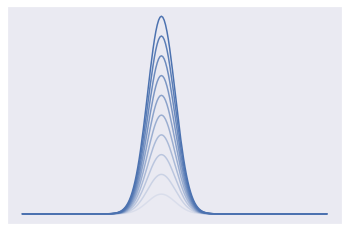

In [207]:
place_field = scipy.stats.norm.pdf(np.arange(220),loc=100,scale=10)
scalar_l = numpy.linspace(0.1,1,10)
fig,ax=plt.subplots()
for i in range(len(scalar_l)):
    ax.plot(place_field * scalar_l[i],alpha=scalar_l[i],c='C0')
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
#     ax.spines.top.set_visible(False)
#     ax.spines.right.set_visible(False)

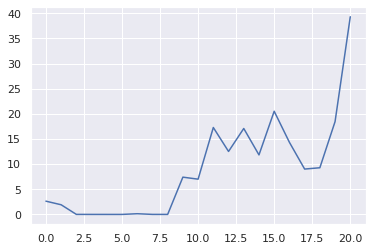

In [246]:
plt.plot(fr_map_[0][1][40:60].max(axis=0))

In [264]:
uid=44
unit_ind=numpy.nonzero(numpy.array(fr_['cell_cols']['pyr'],dtype=object)==f'unit_{uid}')[0][0]

In [266]:
scipy.signal.find_peaks(fr_map_[0][unit_ind][:,0])

(array([ 3, 20, 55]), {})

In [320]:
def find_peak_select_surround(x_,search_range=None,halfspan=5):
    if search_range is not None:
        x = x_[search_range[0]:search_range[1]]
        st_ind=search_range[0]
    else:
        x=x_
        st_ind=0
    peak_ind = numpy.argmax(x)
    st_final,end_final = (st_ind+peak_ind-halfspan), (st_ind+peak_ind+halfspan)
    x_selected=x_[st_final:end_final]
    peak_val = x[peak_ind]
    peak_ind_final=st_ind+peak_ind
    return x_selected, peak_ind_final,peak_val, st_final,end_final

In [321]:
frmap_selected

array([0.20518322, 0.38221228, 0.5464852 , 0.68530905, 0.77945128,
       0.8023722 , 0.74171664, 0.61213698, 0.44877624, 0.29015403])

In [354]:
def plot_centered_placefield_by_trial(fr_map_,unit_ind,trials_l = range(9),**kwargs):
    fig,ax=plt.subplots(figsize=(3,4))
    
    scalar_l = numpy.linspace(0.1,1,len(trials_l))
    startind=40
    endind=60
    halfspan = 10
    peak_val_l = []
    for i in trials_l:
        frmap_unit = fr_map_[0][unit_ind]

        frmap_selected,peak_ind_final,peak_val,st_final,end_final=find_peak_select_surround(frmap_unit[:,i],search_range=(startind,endind),halfspan=halfspan)
    #     st_final=st_within+startind
    #     end_final=startind+end_within
        peak_val_l.append(peak_val)
        ax.plot(numpy.arange(-halfspan,halfspan),frmap_selected,alpha=scalar_l[i],c='C0')
    xticks = numpy.array([-10,-5,0,5,10])
    ax.set_xticks(xticks,xticks*2)
    ax.set_xlabel('Position (cm)')
    ax.set_ylabel('Firing Rate (Hz)')
    peak_val_l  =numpy.array(peak_val_l)
    return peak_val_l,fig,ax

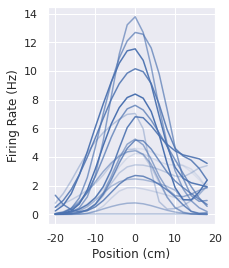

In [355]:
peak_val_l,fig,ax = plot_centered_placefield_by_trial(fr_map_,unit_ind,trials_l=range(20))

In [378]:
def plot_threshed_place_field_onoff(peak_val_l,thresh_fr=2):
    fig,ax=plt.subplots()
    ax.scatter(numpy.arange(len(peak_val_l)),peak_val_l>thresh_fr)
    ax.set_xticks(numpy.arange(0,len(peak_val_l),5))
    ax.set_yticks([0,1])
    ax.set_xlabel('trial')
    ax.set_ylabel('Place Field or Not')
    return fig,ax

In [379]:
sns.set(font_scale=1.5)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='trial', ylabel='Place Field or Not'>)

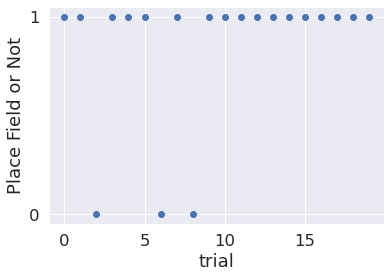

In [380]:
thresh_fr=2
# plt.scatter(numpy.arange(len(peak_val_l)),peak_val_l>thresh_fr)
plot_threshed_place_field_onoff(peak_val_l,thresh_fr=thresh_fr)

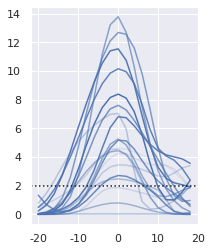

In [349]:
ax.axhline(thresh_fr,linestyle=':',color='k')
fig

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='trial', ylabel='Place Field or Not'>)

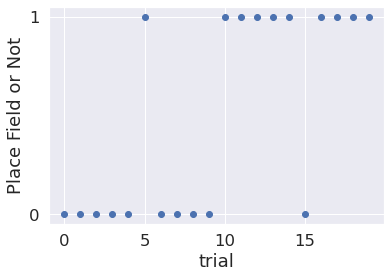

In [381]:
thresh_fr=5
plot_threshed_place_field_onoff(peak_val_l,thresh_fr=thresh_fr)

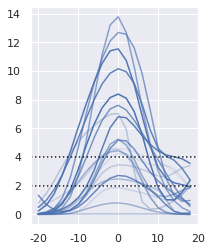

In [351]:
ax.axhline(thresh_fr,linestyle=':',color='k')
fig

Text(0, 0.5, 'Peak Firing Rate (Hz)')

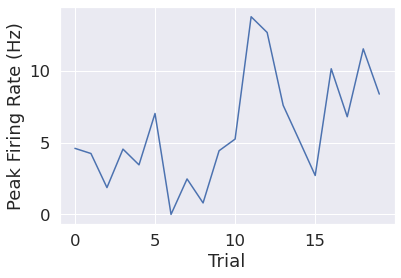

In [384]:
plt.plot(peak_val_l)
plt.xlabel('Trial')
plt.ylabel('Peak Firing Rate (Hz)')

# demonstrate block CV

In [643]:
args=pr.preprocess_for_plot(sess_name,sigma=30,speedmask=5,n_pos_bins=100)

Text(0.5, 0, 'Position (cm)')

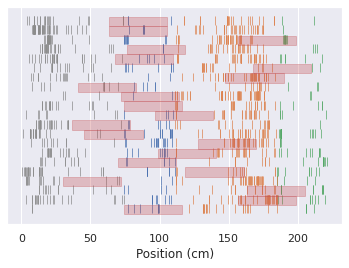

In [664]:
section_colordict,spk_triggered_positions_trial_all_speedmasked,pos_bins_dict,choice = args[4:8]
ind = 0
uid_l = fr_['cell_cols']['pyr']
uid = uid_l[ind] # 1 indexed
uid_num = int(uid.split('_')[1])-1 # 0 indexed

spk_triggered_positions_trial_one_unit = spk_triggered_positions_trial_all_speedmasked[uid_num]
spk_triggered_positions_trial  = spk_triggered_positions_trial_one_unit


ch=0
fr_map_trial = fr_map_
ys_l = fr_map_trial[ch][ind]
trial_mask = choice==ch
spk_triggered_positions_trial_ = spk_triggered_positions_trial[trial_mask]

fig,ax=gp.plot_raster_1d_1trial(spk_triggered_positions_trial_,ch=0,fig=None,ax=None,spk_displacement_ratio=0.1,displacement=20,section_colordict=None,scatter_kwargs_={})

import gm_cv as gmcv
reload(gpd)
ntrials = ys_l.shape[1]
mask = gmcv.get_train_test_mask(100,ntrials,ratio_consec_bins_to_mask=0.2)
fig,ax=gpd.plot_masks(mask,displacement=20,bin_to_lin=bin_to_lin,fig=fig,ax=ax)
ax.set_yticks([])
ax.set_xlabel('Position (cm)')

[]

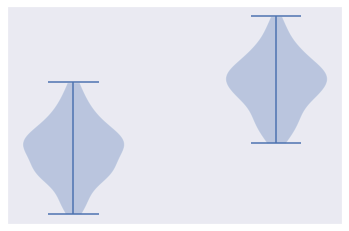

In [682]:
fig,ax=plt.subplots()
x1=numpy.random.normal(size=(100,))
x2=numpy.random.normal(size=(100,))+2
plt.violinplot([x1,x2])
ax.set_xticks([])
ax.set_yticks([])

# schematic for surveying the population

In [759]:
x1 =numpy.array([0,0.1,0,0.2,1,1.5,1.2,1.3,1.1,1.6])
ntrials= len(x1)
x2 = x1 + numpy.random.normal(scale=0.2,size=(len(x1),))**2
x3 = numpy.random.normal(loc=1,scale=0.1,size=(len(x1),))
X = numpy.stack([x1,x2,x3],axis=1)

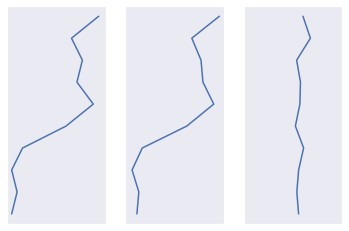

In [769]:
fig,ax=plt.subplots(1,3,sharex=True,sharey=True)

# ax[1].plot(x2)
# ax[2].plot(x3)
# ax[2].set_ylim([0,1.6])
for i in range(X.shape[1]):
    ax[i].plot(X[:,i],numpy.arange(ntrials))
    ax[i].set_yticks([])
    ax[i].set_xticks([])



In [716]:
from sklearn.decomposition import NMF

In [765]:
nmf = NMF(n_components=2)
W = nmf.fit_transform(X)
H = nmf.components_

In [766]:
H

array([[2.0842602 , 2.0908608 , 0.33951775],
       [0.        , 0.11274385, 1.72962659]])

([], [])

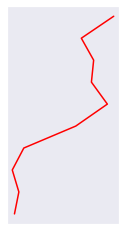

In [777]:
fig,ax=plt.subplots(figsize=(2,4))
plt.plot(W[:,0],numpy.arange(ntrials),c='red')
plt.yticks([])
plt.xticks([])

[]

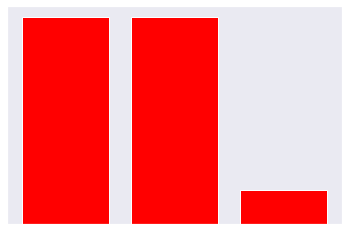

In [778]:
fig,ax=plt.subplots()
ax.bar(numpy.arange(H.shape[1]),H[0,:],color='red')
# plt.barh(numpy.arange(H.shape[1]),H[1,:])
# ax.invert_xaxis()
# ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])